In [1]:
from plotting import imshow
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# RGB training data load
yuv_train_set = unpickle('yuv_train')

# Image names 
filenames = [f.decode('utf-8') for f in yuv_train_set[b'filenames']]

# Getting the images
yuv_images_data = yuv_train_set[b'data'].copy() 

In [27]:
# Input tensor(H,W,C) -> output tensor(C,H,W)
def yuv_rgb(array):
    new_array = array.numpy().astype(np.float32).copy()
    new_array = cv2.cvtColor(new_array, cv2.COLOR_YUV2RGB)
    return torch.tensor((new_array*255).astype(np.uint8)).permute(2, 0, 1)

In [5]:
import matplotlib.pyplot as plt

In [ ]:
class YUVImageClassificationDataset(Dataset):
    def __init__(self, filenames, images_data, bin_count=50):
        self.filenames = filenames # image name
        self.images_data = images_data # images data: data used to construct the images 
        self.bin_count = bin_count # number of bins used 
        self.bins = np.linspace(0, 1, bin_count)  # Bin edges
        # we are creating bins between 0 and 1 in order to have the values of u and v

    def __len__(self):
        return len(self.filenames)
    
    def bin_labels(self, values):
        return np.digitize(values, self.bins) -1 # Map values to bin indices
                                                   # This function takes values and assigns each value to a bin index
                                                   # based on self.bins. It returns the index starting from 0

    def __getitem__(self, idx):
        # Creating image from the dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint8)

        Y_channel = img[0:1024].reshape(32, 32, 1) / 255
        U_channel = img[1024:2048].reshape(32, 32, 1) / 255
        V_channel = img[2048:].reshape(32, 32, 1) / 255
        #return y, u, v, self.filenames[idx]

    
        #return Y_channel, U_channel, V_channel, self.filenames[idx]

        # Binned shapes are (H,W)
        U_binned = self.bin_labels(U_channel)  # Discretize U 
        V_binned = self.bin_labels(V_channel)  # Discretize V


        return Y_channel, U_binned, V_binned, self.filenames[idx]



### Creating a lookup table

In [7]:
bin_count = 50
bins = np.linspace(0, 1, bin_count)
lookup_table = torch.zeros(50).to(device) 
for idx, value in enumerate(bins):
    lookup_table[idx] = value

def unbin_labels(bin_indices):
    return lookup_table[bin_indices]

In [8]:
# Loading the RGB images
yuv_dataset = YUVImageClassificationDataset(filenames=filenames, images_data=yuv_images_data)
yuv_train_loader = DataLoader(yuv_dataset, batch_size=8, shuffle = False)

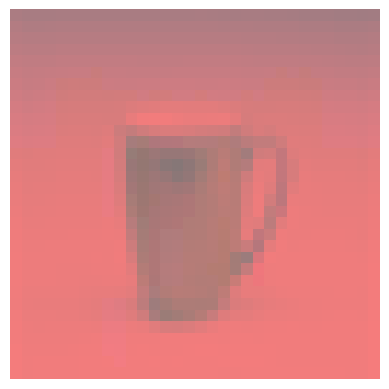

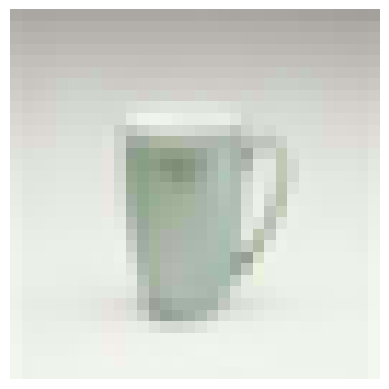

In [29]:
import matplotlib.pyplot as plt
for Y_channel, U_binned, V_binned, fname in yuv_train_loader:

    
    # shape (8,32,32,1) 
    U_target_rec = unbin_labels(U_binned.clone().detach())
    V_target_rec = unbin_labels(V_binned.clone().detach())
    
    #shape (8,3,32,32)
    img_batch = torch.cat([Y_channel.cpu(),U_target_rec.cpu(),V_target_rec.cpu()],dim=3).permute(0,3,1,2)
    
    imggg = img_batch[7]
    imshow(imggg)
    rgb_output = yuv_rgb(imggg.permute(1,2,0))

    imshow(rgb_output) 
    
    
    break

In [ ]:
# ----- CLASSIFICATION CNN MODEL -----
class ClassificationCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(ClassificationCNN, self).__init__()
        
        # Initial Convolutional Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Skip Connections
        self.skip0 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
        
        self.conv_final = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        
        # Output Layers for Classification
        self.output_U = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        self.output_V = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x1_pooled = self.pool1(x1)
        
        x2 = self.conv2(x1_pooled)
        x2_pooled = self.pool2(x2)
        x2_pooled_padded = F.interpolate(x2_pooled, size=(32, 32), mode='bilinear', align_corners=False)

        x1_conv = self.skip0(x1)
        x2_padded = F.interpolate(x2, size=(32, 32), mode='bilinear', align_corners=False)
        el_wise = x1_conv + x2_padded
        
        # Concatenation layer
        x_concat = torch.cat([el_wise, x2_pooled_padded], dim=1) # necessitano solo stessa H e W

        # Final convolutional processing
        x_final = self.conv_final(x_concat)

        U_out = self.output_U(x_final)
        V_out = self.output_V(x_final)

        return U_out, V_out

In [ ]:

bin_count = 50
model = ClassificationCNN(bin_count).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
total_loss = []
# Training Loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for Y_channel, U_target, V_target, fname in yuv_train_loader:
        Y_channel, U_target, V_target = Y_channel.to(device), U_target.to(device), V_target.to(device)
        #print('U target: \n', U_target)

        optimizer.zero_grad()
        U_pred, V_pred = model(Y_channel)
        #print('U pred: \n',U_pred)

        loss_U = criterion(U_pred, U_target)
        loss_V = criterion(V_pred, V_target)
        loss = loss_U + loss_V

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(yuv_train_loader):.4f}")

# Save Model
torch.save(model.state_dict(), f"models/yuv_classification_{num_epochs}ep.pth")

In [ ]:
def converter(pred):
    softmax = nn.Softmax(dim = 1).to(device)
    probs = softmax(pred)
    _, ind = torch.topk(probs,1,1)
    return ind

In [ ]:
bin_count = 50
bins = np.linspace(0, 1, bin_count)
lookup_table = torch.zeros(50).to(device) 
for idx, value in enumerate(bins):
    lookup_table[idx] = value

def unbin_labels(bin_indices):
    return lookup_table[bin_indices]

In [ ]:
model.load_state_dict(torch.load("models/yuv_classification_30ep.pth"))

In [ ]:
for Y_channel, U_target, V_target, fname in yuv_train_loader:
    Y_channel, U_target, V_target = Y_channel.to(device), U_target.to(device), V_target.to(device)
    
    U_pred, V_pred = model(Y_channel)
    #not sure
    conv_pred_U = converter(U_pred.cpu())
    conv_pred_V = converter(V_pred.cpu())

    pred_U_rec = unbin_labels(conv_pred_U.clone().detach())
    #print(pred_U_rec.size())
    #pred_U_rec_tensor = torch.tensor(pred_U_rec, dtype=torch.float32).resize(8,1,32,32)
    pred_V_rec = unbin_labels(conv_pred_V.clone().detach())
    #pred_V_rec_tensor = torch.tensor(pred_V_rec, dtype=torch.float32).resize(8,1,32,32)
    reconstructed_pred = torch.cat([Y_channel.cpu(),pred_U_rec.cpu(),pred_V_rec.cpu()],dim=3).permute(0,3,1,2)

    U_target_rec = unbin_labels(U_target)
    #U_target_rec_tensor = torch.tensor(U_target_rec, dtype=torch.float32).resize(8,1,32,32)

    V_target_rec = unbin_labels(V_target)
    reconstructed_img = torch.cat([Y_channel.cpu(),U_target_rec.cpu(),V_target_rec.cpu()],dim=3).permute(0,3,1,2)
    #V_target_rec_tensor = torch.tensor(V_target_rec , dtype=torch.float32).resize(8,1,32,32)

    #reconstructed_pred = torch.cat([Y_channel,pred_U_rec_tensor,pred_V_rec_tensor],dim=1)
    
    #reconstructed_img = torch.cat([Y_channel,U_target_rec_tensor,V_target_rec_tensor],dim=1)

    image_yuv = reconstructed_img[0]  # Frist image of the batch (YUV)
    image_yuv_pred = reconstructed_pred[0]

    # Need to resize first
    rgb_output = yuv_rgb(image_yuv.permute(1,2,0))
    rgb_output_pred = yuv_rgb(image_yuv_pred.permute(1,2,0))

    print(f"Filename: {fname[0]}")

    #imshow(rgb_output) 
    imshow(rgb_output_pred) 
    
    
    break